In [ ]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import cv2
import os

from sklearn.model_selection import train_test_split

from skimage.transform import resize

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from keras.preprocessing.image import load_img
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

In [ ]:
img_size_ori = 101
img_size_target = 128

augment_img_path = ''
augment_mask_path = ''
num_img_aug = 4000

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

# Loading of training/testing ids and depths

In [ ]:
train_df = pd.read_csv("../../../data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../../../data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks

In [4]:
# Read images
train_df["images"] = [np.array(load_img("../../../data/train/images/{}.png".format(idx), color_mode="grayscale")) / 255 for idx in tqdm(train_df.index)]

In [5]:
# Read mask images
train_df["masks"] = [np.array(load_img("../../../data/train/masks/{}.png".format(idx), color_mode="grayscale")) / 255 for idx in tqdm(train_df.index)]

# Calculating the salt coverage and salt coverage classes

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [7]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

C:\Users\Natthawat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Natthawat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

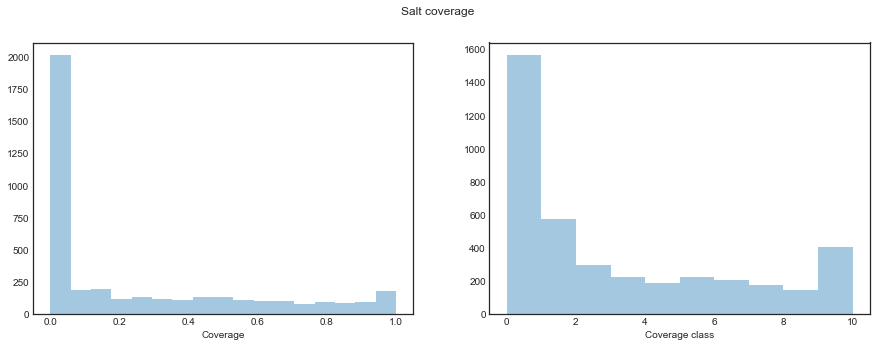

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

C:\Users\Natthawat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Natthawat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

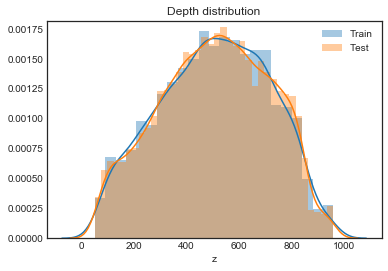

In [9]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

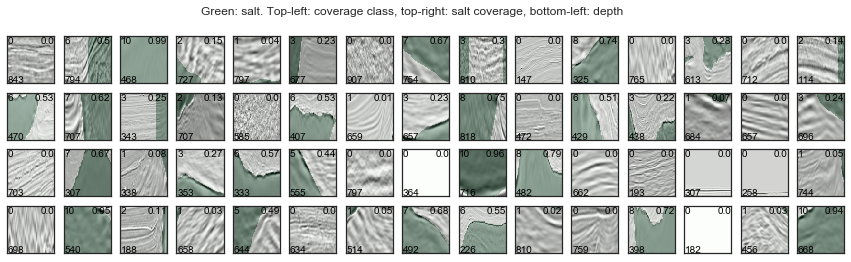

In [10]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [11]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

Text(0.5,1,'Scaled image')

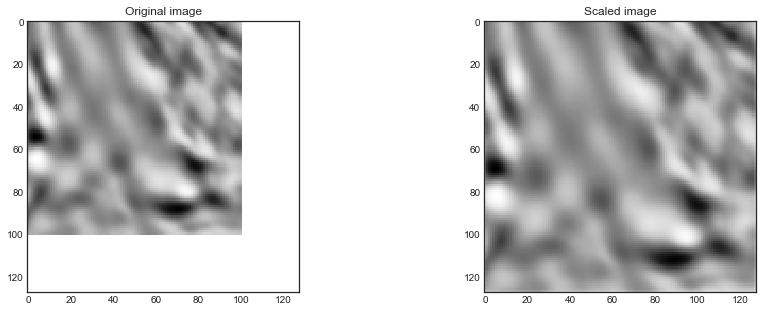

In [12]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

# Load images augmentation

In [13]:
img_aug = [np.array(load_img("../../../data/aug-1/images/{}.jpg".format(str(i)), color_mode="grayscale")) / 255 for i in range(num_img_aug)]

In [14]:
mask_aug = [np.array(load_img("../../../data/aug-1/images/{}.jpg".format(str(i)), color_mode="grayscale")) / 255 for i in range(num_img_aug)]

In [15]:
aug_df = pd.DataFrame(data={'images': img_aug, 'masks': mask_aug})

In [16]:
train_img_aug = np.array(aug_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
mask_img_aug = np.array(aug_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)

In [17]:
x_train = np.append(x_train, train_img_aug, axis=0)
y_train = np.append(y_train, mask_img_aug, axis=0)

In [18]:
print(x_train.shape)
print(y_train.shape)

(7200, 128, 128, 1)
(7200, 128, 128, 1)


# Model

In [19]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

# Define Loss Function

In [20]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

In [21]:
model = Model(input_layer, output_layer)
model.compile(loss=bce_dice_loss, optimizer="adam", metrics=["accuracy", my_iou_metric])

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

# Training

In [23]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint('./keras.model', save_best_only=True, monitor='val_my_iou_metric', mode = 'max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.2, patience=5, min_lr=0.0001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr],
                    shuffle=True,
                    verbose=2)

Train on 7200 samples, validate on 800 samples
Epoch 1/200
 - 31s - loss: 1.2652 - acc: 0.3293 - my_iou_metric: 0.1582 - val_loss: 1.1698 - val_acc: 0.7468 - val_my_iou_metric: 0.3900

Epoch 00001: val_my_iou_metric improved from -inf to 0.39000, saving model to ./keras.model
Epoch 2/200
 - 23s - loss: 1.1943 - acc: 0.3355 - my_iou_metric: 0.1201 - val_loss: 1.0088 - val_acc: 0.8072 - val_my_iou_metric: 0.2427

Epoch 00002: val_my_iou_metric did not improve from 0.39000
Epoch 3/200
 - 23s - loss: 1.1237 - acc: 0.3590 - my_iou_metric: 0.1428 - val_loss: 0.9414 - val_acc: 0.8055 - val_my_iou_metric: 0.3044

Epoch 00003: val_my_iou_metric did not improve from 0.39000
Epoch 4/200
 - 23s - loss: 1.0932 - acc: 0.3670 - my_iou_metric: 0.2088 - val_loss: 0.8360 - val_acc: 0.8255 - val_my_iou_metric: 0.4689

Epoch 00004: val_my_iou_metric improved from 0.39000 to 0.46888, saving model to ./keras.model
Epoch 5/200
 - 23s - loss: 1.0622 - acc: 0.3738 - my_iou_metric: 0.2295 - val_loss: 0.8348 - v


Epoch 00080: val_my_iou_metric did not improve from 0.64337
Epoch 81/200
 - 25s - loss: 0.8206 - acc: 0.4193 - my_iou_metric: 0.3199 - val_loss: 0.4432 - val_acc: 0.9083 - val_my_iou_metric: 0.6460

Epoch 00081: val_my_iou_metric improved from 0.64337 to 0.64600, saving model to ./keras.model
Epoch 82/200
 - 25s - loss: 0.8167 - acc: 0.4199 - my_iou_metric: 0.3240 - val_loss: 0.4653 - val_acc: 0.9037 - val_my_iou_metric: 0.6285

Epoch 00082: val_my_iou_metric did not improve from 0.64600
Epoch 83/200
 - 26s - loss: 0.8167 - acc: 0.4197 - my_iou_metric: 0.3202 - val_loss: 0.4768 - val_acc: 0.9008 - val_my_iou_metric: 0.6215

Epoch 00083: val_my_iou_metric did not improve from 0.64600
Epoch 84/200
 - 26s - loss: 0.8141 - acc: 0.4205 - my_iou_metric: 0.3215 - val_loss: 0.4957 - val_acc: 0.8945 - val_my_iou_metric: 0.5984

Epoch 00084: val_my_iou_metric did not improve from 0.64600
Epoch 85/200
 - 26s - loss: 0.8177 - acc: 0.4196 - my_iou_metric: 0.3190 - val_loss: 0.4927 - val_acc: 0.897


Epoch 00121: val_my_iou_metric did not improve from 0.64600
Epoch 122/200
 - 25s - loss: 0.7926 - acc: 0.4246 - my_iou_metric: 0.3348 - val_loss: 0.5443 - val_acc: 0.8926 - val_my_iou_metric: 0.6003

Epoch 00122: val_my_iou_metric did not improve from 0.64600
Epoch 123/200
 - 26s - loss: 0.7912 - acc: 0.4247 - my_iou_metric: 0.3351 - val_loss: 0.5246 - val_acc: 0.8925 - val_my_iou_metric: 0.5687

Epoch 00123: val_my_iou_metric did not improve from 0.64600
Epoch 124/200
 - 25s - loss: 0.7904 - acc: 0.4249 - my_iou_metric: 0.3317 - val_loss: 0.4614 - val_acc: 0.9055 - val_my_iou_metric: 0.6222

Epoch 00124: val_my_iou_metric did not improve from 0.64600
Epoch 125/200
 - 25s - loss: 0.7871 - acc: 0.4253 - my_iou_metric: 0.3330 - val_loss: 0.4711 - val_acc: 0.9045 - val_my_iou_metric: 0.6124

Epoch 00125: val_my_iou_metric did not improve from 0.64600
Epoch 126/200
 - 26s - loss: 0.7927 - acc: 0.4243 - my_iou_metric: 0.3327 - val_loss: 0.5354 - val_acc: 0.8910 - val_my_iou_metric: 0.5734



Epoch 00162: val_my_iou_metric did not improve from 0.64600
Epoch 163/200
 - 25s - loss: 0.7679 - acc: 0.4281 - my_iou_metric: 0.3446 - val_loss: 0.5230 - val_acc: 0.9069 - val_my_iou_metric: 0.6349

Epoch 00163: val_my_iou_metric did not improve from 0.64600
Epoch 164/200
 - 25s - loss: 0.7717 - acc: 0.4278 - my_iou_metric: 0.3429 - val_loss: 0.4995 - val_acc: 0.9116 - val_my_iou_metric: 0.6154

Epoch 00164: val_my_iou_metric did not improve from 0.64600
Epoch 165/200
 - 25s - loss: 0.7682 - acc: 0.4286 - my_iou_metric: 0.3502 - val_loss: 0.5349 - val_acc: 0.8972 - val_my_iou_metric: 0.6046

Epoch 00165: val_my_iou_metric did not improve from 0.64600
Epoch 166/200
 - 25s - loss: 0.7706 - acc: 0.4281 - my_iou_metric: 0.3435 - val_loss: 0.5246 - val_acc: 0.9061 - val_my_iou_metric: 0.6088

Epoch 00166: val_my_iou_metric did not improve from 0.64600
Epoch 167/200
 - 25s - loss: 0.7682 - acc: 0.4286 - my_iou_metric: 0.3466 - val_loss: 0.5326 - val_acc: 0.9008 - val_my_iou_metric: 0.5924


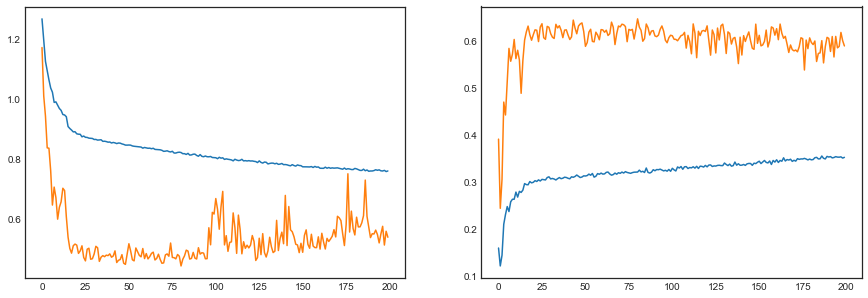

In [24]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["my_iou_metric"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation accuracy")

In [42]:
model.load_weights('./keras.model')

In [43]:
# Predict the validation set to do a sanity check

In [44]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict([x_test]).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict([x_test_reflect]).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [45]:
preds_valid = predict_result(model,x_valid,img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([downsample(x) for x in y_valid])

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

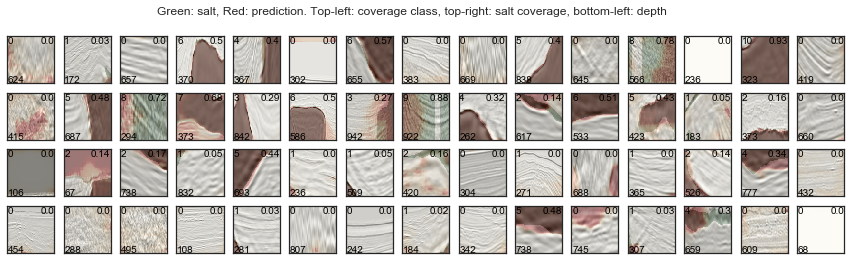

In [46]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [47]:
# Scoring

In [49]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [50]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm(thresholds)])

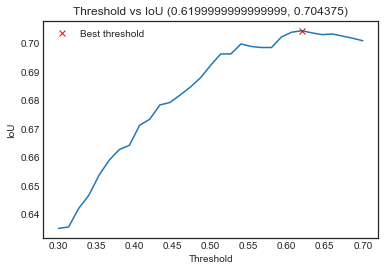

In [51]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [34]:
threshold_best

0.6199999999999999

# Another sanity check with adjusted threshold

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

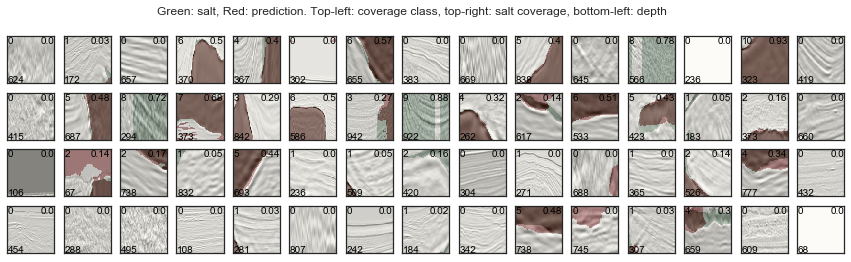

In [52]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Submission

In [53]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [54]:
x_test = np.array([upsample(np.array(load_img("../../../data/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Natthawat\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  war

In [55]:
preds_test = model.predict(x_test)

In [56]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm(test_df.index.values))}

In [58]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [59]:
print('Score from kaggle simmission is 0.656483')

Score from kaggle simmission is 0.656483
